In [3]:
f = open('mini_classes.txt',"r")
classes = f.readlines()
f.close()

In [4]:
classes = [c.replace('\n','').replace(' ','_') for c in classes]

In [5]:
!mkdir data

mkdir: cannot create directory ‘data’: File exists


In [6]:
import urllib.request
def download():
  base = 'https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/'
  for c in classes:
    cls_url = c.replace('_','%20')
    path = base+cls_url+'.npy'
    print(path)
    urllib.request.urlretrieve(path, 'data/'+c+'.npy')

In [7]:
download()

https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/drums.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/sun.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/laptop.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/anvil.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/baseball%20bat.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/ladder.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/eyeglasses.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/grapes.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/book.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/dumbbell.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/traffic%20light.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/wristwatch.npy
https://storage.googleapis.com/quickdraw_dat

In [8]:
import os
import glob
import numpy as np
import tensorflow as tf
from tensorflow import keras

print(len(os.listdir('data')))

100


In [9]:
def load_data(root, vfold_ratio=0.2, max_items_per_class=4000):
  all_files = glob.glob(os.path.join(root,'*.npy'))

  x = np.empty([0,784])
  y = np.empty([0])
  class_names = []

  for idx, file in enumerate(all_files):
    data = np.load(file)
    data = data[0:max_items_per_class, :]
    labels = np.full(data.shape[0], idx)

    x = np.concatenate((x,data), axis=0)
    y = np.append(y,labels)
    class_name, ext = os.path.splitext(os.path.basename(file))
    class_names.append(class_name)

  data = None
  labels = None
  permutation = np.random.permutation(y.shape[0])
  x = x[permutation, :]
  y = y[permutation]
  vfold_size = int(x.shape[0]/100*(vfold_ratio*100))

  x_test = x[0:vfold_size,:]
  y_test = y[0:vfold_size]
  x_train = x[vfold_size:x.shape[0],:]
  y_train = y[vfold_size:y.shape[0]]

  return x_train, y_train, x_test, y_test, class_names

In [10]:
x_train, y_train, x_test, y_test, class_names = load_data('data')
num_classes = len(class_names)
image_size = 28

In [11]:
len(x_train)

320000

line


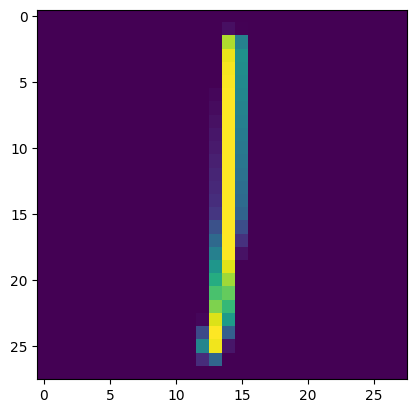

In [12]:
from matplotlib import pyplot as plt
from random import randint
%matplotlib inline
idx = randint(0,len(x_train))
plt.imshow(x_train[idx].reshape(image_size,image_size))
print(class_names[int(y_train[idx].item())])

In [13]:
x_train = x_train.reshape(x_train.shape[0], image_size, image_size, 1).astype('float32')
x_test = x_test.reshape(x_test.shape[0], image_size, image_size, 1).astype('float32')
x_train /= 255.0
x_test /= 255.0
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [14]:
model = keras.Sequential([
    keras.layers.Conv2D(16,(3,3), padding='same',input_shape=x_train.shape[1:], activation='relu'),
    keras.layers.MaxPooling2D((2,2)),
    keras.layers.Conv2D(32,(3,3), padding='same', activation='relu'),
    keras.layers.MaxPooling2D((2,2)),
    keras.layers.Conv2D(64, (3,3), padding='same', activation='relu'),
    keras.layers.MaxPooling2D((2,2)),

    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(100,activation='softmax')
])
model.compile(
    optimizer = 'adam',
    loss = 'categorical_crossentropy',
    metrics = ['top_k_categorical_accuracy']
)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [15]:
model.fit(x_train,y_train, validation_split=0.1, batch_size=256, verbose=2, epochs=5)

Epoch 1/5
1125/1125 - 205s - 182ms/step - loss: 1.9668 - top_k_categorical_accuracy: 0.7738 - val_loss: 1.4104 - val_top_k_categorical_accuracy: 0.8716
Epoch 2/5
1125/1125 - 253s - 225ms/step - loss: 1.2640 - top_k_categorical_accuracy: 0.8901 - val_loss: 1.1990 - val_top_k_categorical_accuracy: 0.8953
Epoch 3/5
1125/1125 - 201s - 179ms/step - loss: 1.1026 - top_k_categorical_accuracy: 0.9081 - val_loss: 1.0885 - val_top_k_categorical_accuracy: 0.9095
Epoch 4/5
1125/1125 - 203s - 181ms/step - loss: 1.0115 - top_k_categorical_accuracy: 0.9178 - val_loss: 1.0403 - val_top_k_categorical_accuracy: 0.9135
Epoch 5/5
1125/1125 - 193s - 172ms/step - loss: 0.9519 - top_k_categorical_accuracy: 0.9236 - val_loss: 1.0049 - val_top_k_categorical_accuracy: 0.9176


In [16]:
model.evaluate(x_test,y_test,verbose=0)[1]

0.9193000197410583

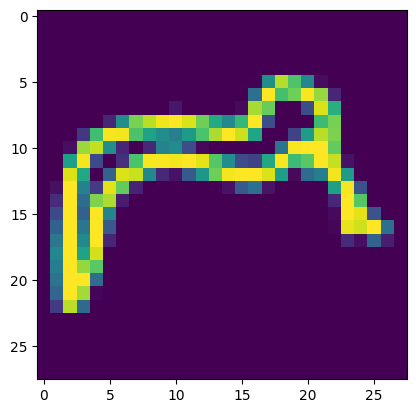

In [17]:
idx = randint(0,len(x_test))
img = x_test[idx]
plt.imshow(img.squeeze())

In [18]:
pred = model.predict(np.expand_dims(img,axis=0))[0]
ind = (-pred).argsort()[:5]
latex = [class_names[x] for x in ind]
print(latex)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
['axe', 'bridge', 'mountain', 'rainbow', 'diving_board']


In [19]:
with open('class_names.txt','w') as file_handler:
  for item in class_names:
    file_handler.write("{}\n".format(item))

In [20]:
model.save('keras.h5')

In [21]:
!mkdir model
!tensorflowjs-converter --input_format keras keras.h5 model/

/bin/bash: line 1: tensorflowjs-converter: command not found


In [22]:
!cp class_names.txt model/class_names.txt

In [23]:
!zip -r model.zip model

  adding: model/ (stored 0%)
  adding: model/class_names.txt (deflated 42%)


In [24]:
from google.colab import files
files.download('model.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>